In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, models

import os
import sys
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append('../src')
from densenet import densenet_cifar

In [3]:
plt.style.use('seaborn-darkgrid')

In [4]:
data_dir = '../data/kaggle/test/'

In [5]:
mapping = {
    'airplane': 0,
    'automobile': 1,
    'bird': 2,
    'cat': 3,
    'deer': 4,
    'dog': 5,
    'frog': 6,
    'horse': 7,
    'ship': 8,
    'truck': 9,
}

reverse_mapping = {val: key for key, val in mapping.items()}

In [6]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
])

In [7]:
class Summary:
    def __init__(self, model_class):
        self._model_class = model_class
        self._epochs = {
            'train': [],
            'valid': []
        }
        self._losses = {
            'train': [],
            'valid': []
        }
        self._accuracies = {
            'train': [],
            'valid': []
        }
        
        self._best = {
            'accuracy': 0,
            'weights': None
        }
        
        self._lr = []
        
        self._start = 0
        self._durations = [0]
        
    def start(self):
        self._start = time.time()
    
    def stop(self):
        if self._start == 0:
            raise RuntimeException('Executing Summary.stop() without Summary.start()')
        self._durations.append(time.time() - self._start)
        self._start = 0
    
    def set_best(self, accuracy, weights):
        self._best['accuracy'] = accuracy
        self._best['weights'] = weights
    
    @property
    def duration(self):
        return sum(self._durations)
    
    @property
    def best_accuracy(self):
        return self._best['accuracy']
        
    def add(self, epoch, loss, accuracy, lr=None, phase='train'):
        assert phase in ['train', 'valid']
        self._epochs[phase].append(epoch)
        self._losses[phase].append(loss)
        self._accuracies[phase].append(accuracy)
        if not lr is None:
            self._lr.append(lr)
        
    def plot_loss(self, figsize):
        fig = plt.figure(figsize=figsize)
        plt.plot(self._epochs['train'], self._losses['train'], label='Train')
        plt.plot(self._epochs['valid'], self._losses['valid'], label='Valid')
        plt.title('Loss Plot')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def plot_accuracy(self, figsize):
        fig = plt.figure(figsize=figsize)
        plt.plot(self._epochs['train'], self._accuracies['train'], label='Train')
        plt.plot(self._epochs['valid'], self._accuracies['valid'], label='Valid')
        plt.title('Accuracy Plot')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy [%]')
        plt.legend()
        plt.show()
        
    def plot_lr(self, figsize):
        fig = plt.figure(figsize=figsize)
        plt.plot(self._epochs['train'], self._lr)
        plt.title('Learning Rate')
        plt.xlabel('Epochs')
        plt.ylabel('Value')
        plt.show()
        
    def summarise(self):
        print(f'Training complete in {str(datetime.timedelta(seconds=self.duration))}')
        print(f'Total training epochs: {self._epochs["train"][-1]}')
        print(f'Best validation accuracy: {self._best["accuracy"]:.4f}')

In [8]:
class KaggleTestDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.f_names = os.listdir(data_dir)
        self.transform = transform
        
    def __len__(self):
        return len(self.f_names)
    
    def __getitem__(self, idx):
        f_name = self.f_names[idx]
        f_path = os.path.join(self.data_dir, f_name)
        image = Image.open(f_path)
        if not self.transform is None:
            image = self.transform(image)
        return image, f_name.replace('.png', '')

In [9]:
test_dataset = KaggleTestDataset(data_dir, test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
model = densenet_cifar()
model = model.to(device)

In [12]:
def load_best_model(path, model):
    progress_dict = torch.load(path)
    summary = progress_dict['summary']
    model.load_state_dict(summary._best['weights'])
    return model

model = load_best_model('../models/custom_densenet_cos_95', model)

In [13]:
def predict(model, dataloader, class_mapping):
    all_names, all_labels = [], []
    for data, names in tqdm(dataloader):
        data = data.to(device)
        y_preds = model(data)
        pred_labels = torch.argmax(y_preds, dim=1).cpu().data.numpy().tolist()
        all_names += names
        all_labels += pred_labels
        
    df = pd.DataFrame({'id': all_names, 'label': [class_mapping[label] for label in all_labels]})
    return df

In [14]:
df = predict(model, test_loader, reverse_mapping)
# df.to_csv('../data/test/submission.csv')

100%|██████████| 4688/4688 [06:30<00:00, 12.00it/s]


In [15]:
df.head()

,id,label
0,163570,frog
1,193189,cat
2,28347,ship
3,38690,horse
4,63974,deer


In [16]:
len(df)

300000

In [19]:
df_sorted = df.copy()
df_sorted['id'] = df_sorted['id'].apply(int)
df_sorted = df_sorted.sort_values(by=['id'])
df_sorted.head()

,id,label
293082,1,truck
39395,2,airplane
222900,3,automobile
240909,4,ship
85740,5,airplane


In [21]:
for i in tqdm(range(30000)):
    if not df_sorted.loc[i]['label'] == df.loc[i]['label']:
        raise RuntimeError

100%|██████████| 30000/30000 [00:08<00:00, 3642.28it/s]


In [22]:
df_sorted.to_csv('../data/kaggle/submission.csv', index=False)

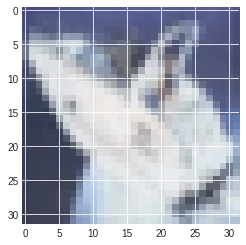

In [21]:
img_id = 28347
img = plt.imread(f'../data/kaggle/test/{img_id}.png')
plt.imshow(img)
plt.show()